<html><h1><center style="color:blue">Human Activity Recognition
</center></h1></html>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np

# Import Keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.regularizers import L1L2

In [ ]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

<html><h1><p style="color:red">Loading Data </p></h1></html>

In [ ]:
# Data directory
DATADIR ="/content/drive/MyDrive/UCI_HAR_Dataset"

# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
    ]

In [ ]:
# Function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Function to load the signals
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'/content/drive/MyDrive/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).to_numpy()
        )

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [ ]:
def load_y(subset):
    """
    The objective that we are trying to predict is an integer, from 1 to 6,
    that represents a human activity. We return a binary representation of
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'/content/drive/MyDrive/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).to_numpy()

In [ ]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

### <html><h1><p style="color:red">Model Architecture using Tensorflow </p></h1></html>

In [ ]:
# Importing tensorflow
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Initializing parameters
epochs = 50
batch_size = 16
n_hidden = 32

In [ ]:
# Function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [ ]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [ ]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D

# Initializing the sequential model
model = Sequential()

# Adding a 1D convolutional layer with 64 filters, kernel size of 3, and ReLU activation function
# Input shape is (timesteps, input_dim)
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(timesteps, input_dim)))

# Adding a 1D max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Adding an LSTM layer with n_hidden units
model.add(LSTM(units=n_hidden))

# Adding a dropout layer
model.add(Dropout(0.5))

# Adding a dense (fully connected) layer with n_classes units and sigmoid activation function
model.add(Dense(units=n_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 126, 64)           1792      
                                                                 
 max_pooling1d (MaxPooling1  (None, 63, 64)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
Total params: 14406 (56.27 KB)
Trainable params: 14406 (56.27 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [ ]:
# Compiling the model
from tensorflow.keras.optimizers import RMSprop

# Define the learning rate
learning_rate = 0.001

# Create optimizer with specified learning rate
optimizer = RMSprop(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
!pip install psutil

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
import psutil

# Record the start time
epochs_start_time = time.time()

# Initialize lists to store metrics for each epoch
loss_history = []
accuracy_history = []
time_per_epoch = []
cpu_usage = []

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    # Start recording time for epoch
    start_time = time.time()

    # Train the model
    history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=1, verbose=1)

    # End recording time for epoch
    end_time = time.time()
    epoch_time = end_time - start_time
    time_per_epoch.append(epoch_time)

    # Record loss and accuracy for training set
    loss_history.append(history.history['loss'][0])
    accuracy_history.append(history.history['accuracy'][0])

    # Record CPU usage (you may need to use a library specific to your platform)
    cpu_usage.append(psutil.cpu_percent())

epochs_end_time = time.time()  # Record the end time
epochs_total_time = epochs_end_time - epochs_start_time  # Calculate the total training time
print("Total training time: {:.2f} seconds".format(epochs_total_time))

Epoch 1/50
460/460 [==============================] - 26s 51ms/step - loss: 0.7595 - accuracy: 0.6926
Epoch 2/50
460/460 [==============================] - 24s 52ms/step - loss: 0.3797 - accuracy: 0.8726
Epoch 3/50
460/460 [==============================] - 12s 26ms/step - loss: 0.2523 - accuracy: 0.9174
Epoch 4/50
460/460 [==============================] - 11s 24ms/step - loss: 0.2171 - accuracy: 0.9314
Epoch 5/50
460/460 [==============================] - 12s 26ms/step - loss: 0.1743 - accuracy: 0.9384
Epoch 6/50
460/460 [==============================] - 12s 25ms/step - loss: 0.1639 - accuracy: 0.9419
Epoch 7/50
460/460 [==============================] - 12s 26ms/step - loss: 0.1426 - accuracy: 0.9463
Epoch 8/50
460/460 [==============================] - 13s 29ms/step - loss: 0.1488 - accuracy: 0.9464
Epoch 9/50
460/460 [==============================] - 11s 25ms/step - loss: 0.1431 - accuracy: 0.9472
Epoch 10/50
460/460 [==============================] - 12s 26ms/step - loss: 0.134

In [ ]:
# Calculate average CPU usage
avg_cpu_usage = sum(cpu_usage)/len(cpu_usage)
print('Average CPU usage: {:.2f}%'.format(avg_cpu_usage))

Average CPU usage: 71.77%


In [ ]:
# Test model
predictions = model(X_test)
predictions = predictions.numpy()
predicted_labels = np.argmax(predictions, axis=1)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, classification_report

# Assuming predicted_classes contains the predicted class labels from your model

# Convert Y_test to multiclass format
Y_test_multiclass = np.argmax(Y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(Y_test_multiclass, predicted_labels)
print("Accuracy:", accuracy)

# Generate classification report
classification_rep = classification_report(Y_test_multiclass, predicted_labels)
print("Classification Report:\n", classification_rep)

Accuracy: 0.9185612487275195
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       496
           1       0.86      0.98      0.92       471
           2       0.99      0.83      0.90       420
           3       0.92      0.78      0.85       491
           4       0.83      0.94      0.88       532
           5       1.00      0.99      1.00       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



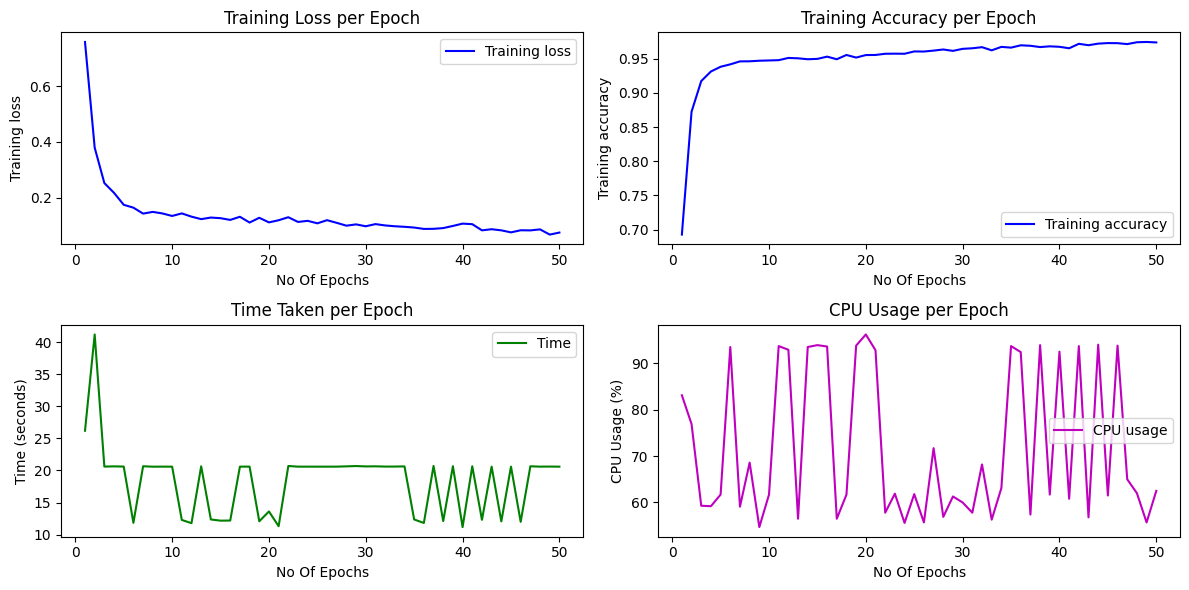

In [ ]:
# Plot the metrics vs. number of epochs
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(2, 2, 1)
plt.plot(epochs_range, loss_history, 'b', label='Training loss')
plt.title('Training Loss per Epoch')
plt.xlabel('No Of Epochs')
plt.ylabel('Training loss')
plt.legend()

# Plot training accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs_range, accuracy_history, 'b', label='Training accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('No Of Epochs')
plt.ylabel('Training accuracy')
plt.legend()

# Plot time taken per epoch
plt.subplot(2, 2, 3)
plt.plot(epochs_range, time_per_epoch, 'g', label='Time')
plt.title('Time Taken per Epoch')
plt.xlabel('No Of Epochs')
plt.ylabel('Time (seconds)')
plt.legend()

# Plot CPU usage per epoch
plt.subplot(2, 2, 4)
plt.plot(epochs_range, cpu_usage, 'm', label='CPU usage')
plt.title('CPU Usage per Epoch')
plt.xlabel('No Of Epochs')
plt.ylabel('CPU Usage (%)')
plt.legend()

plt.tight_layout()
plt.show()

Model Architecture using Pytorch

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Define LSTM model
class CNN_LSTMModel(nn.Module):
    def __init__(self, input_dim, n_hidden, timesteps, n_classes):
        super(CNN_LSTMModel, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3)
        self.maxpool1d = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(input_size=64, hidden_size=n_hidden, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(n_hidden, n_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Swap dimensions to match Conv1D input format
        conv_out = self.conv1d(x)
        maxpool_out = self.maxpool1d(conv_out)
        lstm_out, _ = self.lstm(maxpool_out)
        lstm_out = self.dropout(lstm_out[:, -1, :])  # Apply dropout and get output from last time step
        fc_out = self.fc(lstm_out)
        return fc_out

In [ ]:
# Define function to load data
def load_data():
    # Implement load_signals and load_y functions here to load data
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')
    return X_train, X_test, y_train, y_test

# Initialize parameters
epochs = 50
batch_size = 16
n_hidden = 32

In [ ]:
# Load the data
X_train, X_test, Y_train, Y_test = load_data()

In [ ]:
# Get dimensions
timesteps = X_train.shape[1]
input_dim = X_train.shape[2]
n_classes = Y_train.shape[1]  # Assuming Y_train is one-hot encoded

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# Create DataLoader objects for training and validation data
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Initialize model
model = CNN_LSTMModel(input_dim, n_hidden, timesteps, n_classes)

# Print model summary
print(model)

CNN_LSTMModel(
  (conv1d): Conv1d(9, 64, kernel_size=(3,), stride=(1,))
  (maxpool1d): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(64, 32, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=32, out_features=6, bias=True)
)


In [ ]:
import torch.optim as optim

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer with RMSprop and specific learning rate
learning_rate = 0.001
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

In [ ]:
import torch
import time
import psutil

# Initialize lists to store metrics
train_losses = []
train_accuracies = []
time_per_epoch = []
cpu_usage = []

epochs_start_time = time.time()  # Record the start time

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    start_time = time.time()  # Start recording time for epoch

    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        total_loss += loss.item()

        _, predicted_train = torch.max(outputs, 1)
        correct_train += (predicted_train == labels.argmax(dim=1)).sum().item()
        total_train += labels.size(0)

    # Calculate training loss and accuracy for epoch
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Detach the loss tensor before appending it to the list
    train_losses.append(loss.detach().item()) # Detach and get the scalar value of the loss

    # End recording time for epoch
    end_time = time.time()
    epoch_time = end_time - start_time
    time_per_epoch.append(epoch_time)

    # Record CPU usage
    cpu_usage.append(psutil.cpu_percent())

    # Print metrics for epoch
    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Loss: {loss:.4f}, Accuracy: {train_accuracy:.4f}, "
          f"Time taken: {epoch_time:.2f} s")

epochs_end_time = time.time()  # Record the end time
epochs_total_time = epochs_end_time - epochs_start_time  # Calculate the total training time
print("Total training time: {:.2f} seconds".format(epochs_total_time))

Epoch [1/50], Loss: 0.7202, Accuracy: 0.6274, Time taken: 9.78 s
Epoch [2/50], Loss: 0.9551, Accuracy: 0.7652, Time taken: 9.57 s
Epoch [3/50], Loss: 0.1945, Accuracy: 0.8142, Time taken: 3.62 s
Epoch [4/50], Loss: 0.4863, Accuracy: 0.8730, Time taken: 3.69 s
Epoch [5/50], Loss: 0.2232, Accuracy: 0.8900, Time taken: 4.81 s
Epoch [6/50], Loss: 0.5480, Accuracy: 0.9104, Time taken: 3.72 s
Epoch [7/50], Loss: 0.1213, Accuracy: 0.9153, Time taken: 3.72 s
Epoch [8/50], Loss: 0.0532, Accuracy: 0.9248, Time taken: 4.46 s
Epoch [9/50], Loss: 0.1558, Accuracy: 0.9275, Time taken: 4.18 s
Epoch [10/50], Loss: 0.6460, Accuracy: 0.9338, Time taken: 3.65 s
Epoch [11/50], Loss: 0.2529, Accuracy: 0.9403, Time taken: 3.79 s
Epoch [12/50], Loss: 0.1257, Accuracy: 0.9361, Time taken: 4.80 s
Epoch [13/50], Loss: 0.1066, Accuracy: 0.9442, Time taken: 3.61 s
Epoch [14/50], Loss: 0.0131, Accuracy: 0.9423, Time taken: 3.65 s
Epoch [15/50], Loss: 0.0514, Accuracy: 0.9444, Time taken: 4.64 s
Epoch [16/50], Loss

In [ ]:
# Calculate average CPU usage
avg_cpu_usage = sum(cpu_usage)/len(cpu_usage)
print('Average CPU usage: {:.2f}%'.format(avg_cpu_usage))

Average CPU usage: 66.49%


In [ ]:
import torch
from sklearn.metrics import classification_report

# Evaluate model on the test set
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted_classes = torch.max(outputs, 1)

# Convert true labels to class labels if needed
_, Y_test_multiclass = torch.max(Y_test_tensor, 1)

# Calculate accuracy
accuracy = torch.sum(predicted_classes == Y_test_multiclass).item() / len(Y_test_multiclass)
print("Accuracy:", accuracy)

# Generate classification report
# Convert tensors to numpy arrays
predicted_classes_np = predicted_classes.detach().numpy()
Y_test_multiclass_np = Y_test_multiclass.detach().numpy()

classification_rep = classification_report(Y_test_multiclass_np, predicted_classes_np)
print("Classification Report:\n", classification_rep)

Accuracy: 0.9107567017305734
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96       496
           1       0.93      0.99      0.96       471
           2       0.98      0.91      0.95       420
           3       0.78      0.84      0.81       491
           4       0.83      0.83      0.83       532
           5       1.00      0.96      0.98       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



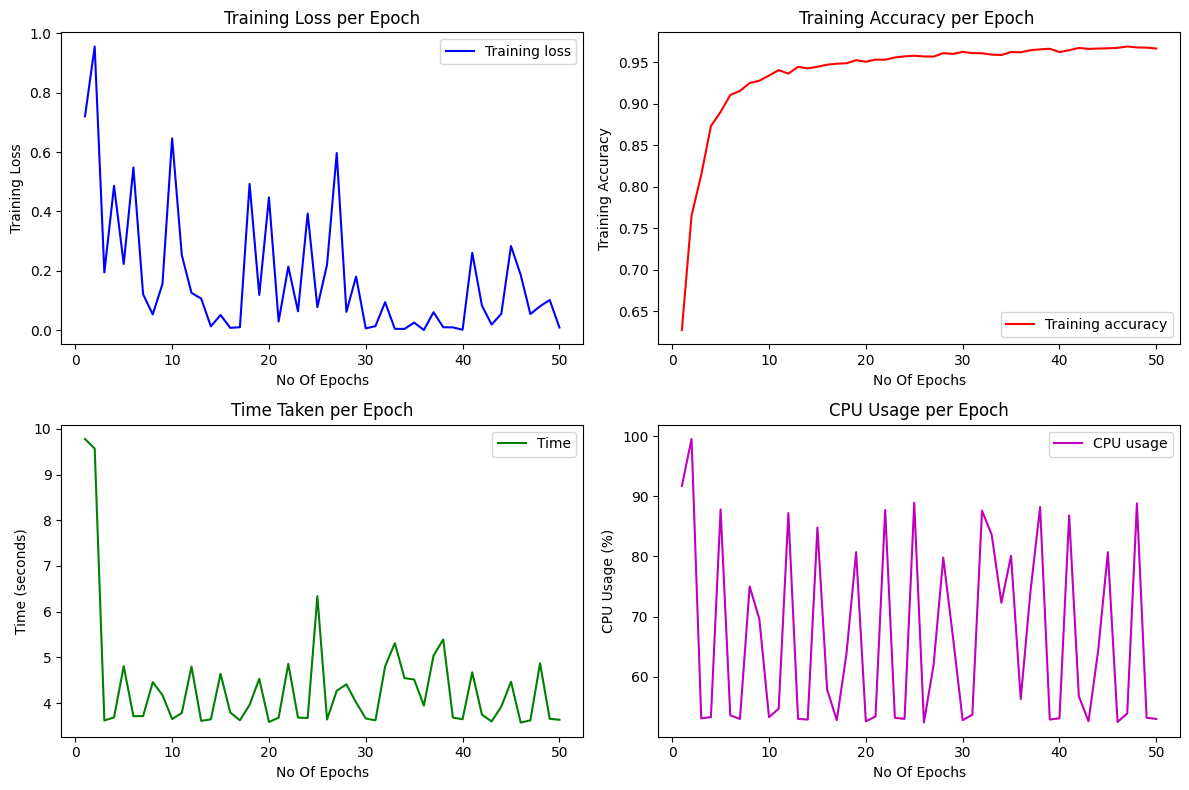

In [ ]:
# Plot the metrics vs. number of epochs
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 8))

# Plot training loss
plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_losses, 'b', label='Training loss')
plt.title('Training Loss per Epoch')
plt.xlabel('No Of Epochs')
plt.ylabel('Training Loss')
plt.legend()

# Plot training accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_accuracies, 'r', label='Training accuracy')
plt.title('Training Accuracy per Epoch ')
plt.xlabel('No Of Epochs')
plt.ylabel('Training Accuracy')
plt.legend()

# Plot time taken per epoch
plt.subplot(2, 2, 3)
plt.plot(epochs_range, time_per_epoch, 'g', label='Time')
plt.title('Time Taken per Epoch')
plt.xlabel('No Of Epochs')
plt.ylabel('Time (seconds)')
plt.legend()

# Plot CPU usage per epoch
plt.subplot(2, 2, 4)
plt.plot(epochs_range, cpu_usage, 'm', label='CPU usage')
plt.title('CPU Usage per Epoch')
plt.xlabel('No Of Epochs')
plt.ylabel('CPU Usage (%)')
plt.legend()

plt.tight_layout()
plt.show()